# Satellite Acquisition

**BEFORE RUNNING THIS CODE: **Download the launch 12 GPS data [here](https://github.com/psas/Launch-12/blob/gh-pages/data/GPS/JGPS%40-32.041913222), and place it in the */resources* folder.

This notebook demonstrates the satellite acquisition proccess, in which we determine which satellites are overhead. This code implements the parallel code phase search algorithm, which is the most complex of those available, but is also the fastest since it returns a result in just one iteration. It is possible that we will need to use a different algorithm when the code is running on an embedded platform.

As noted in the L-12 GPS data README, the sampling frequency is 4.092 MHz. and the IF is 0. Also note that the L1 signal hits the antenna at the 1.57542 GHz frequency (10.23 MHz x 154). This is dealt with by the hardware frontend, so we only have to concern ourselves with the 1.023 MHz BPSK modulated C/A code.

## Preamble

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import struct
import math
import heapq

##Grabs the GoldCode module from the root of the repo
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from GoldCode import GoldCode
from GPSData import IQData

## Import data File

- Information on file "JGPS@04.559925043" can be found at: https://github.com/psas/Launch-12/tree/gh-pages/data/GPS

In [37]:
# Need these to pass to importFile module
fs = 4.092*10**6 # Sampling Frequency [Hz]
NumberOfMilliseconds = 49
#SampleLength = NumberOfMilliseconds*10**(-3) # Sample length in 1ms multiples
SampleLength =0.014
BytesToSkip = 0

data = IQData()
data.importFile('../resources/JGPS@04.559925043', fs, SampleLength, BytesToSkip)

BinWidth = (fs/len(data.CData))
print("BinWidth is: %f [Hz]"%(BinWidth))

Opening a file.
File handle is: 43.
Total Samples to read: 57288
Total Bytes read: 28644.
Which equals 57288 IQ pairs.
Sample Length: 0.014000 seconds.
File is now closed.
BinWidth is: 71.428571 [Hz]


# LO Sweep

- Between these 2 steps we need to sweep the local oscillator due to Doppler effect
- Pick a frequency, and run the steps from here assuming the Doppler shift puts us @ that freq
- We need to multiply the incoming data by a complex sine wave 
- The frequency of the generated wave is equal to the difference between the actual and target frequencies
- The sine wave must be complex in order to get a negative frequency (sweep both directions)
- Book recommends +/- 10kHz in 500Hz steps (pg 77)

## Check out the imported data

We will plot the first 100 samples to see what the signal looks like.

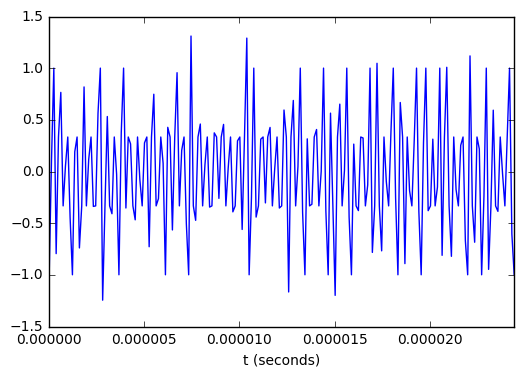

In [38]:
# Convert to real data
tReal, RData = data.ComplexToReal(data.CData)

plt.plot(tReal, RData)

# Set xaxis so first 100 samples are shown
xmin,xmax = plt.xlim()
plt.xlim(xmin,xmin + 100/(fs))

plt.xlabel("t (seconds)")
plt.show()

# View Complex Data Spectrum

We need to take the fft of the IQ datastream.

In [39]:
# Since we are using circular-convolution, nfft must be equal to the number of samples
nfft = data.Nsamples
deltaFreq = fs/nfft
print("Calculated deltaFreq: %f [Hz]" %(deltaFreq))

# Generate frequency lists for plotting fft
# Can use f for regular fft and fshift for shifted version
fs_kHz = fs/1000 #Make easier to read
f = np.linspace (0,fs_kHz,nfft, endpoint=False)
fshift = np.linspace(-fs_kHz/2,fs_kHz/2,nfft,endpoint=False)


# Reference data size section of book to pick the len param. Should be based sample rate
ffC = np.fft.fft(data.CData, nfft)

Calculated deltaFreq: 71.428571 [Hz]


# Plot output

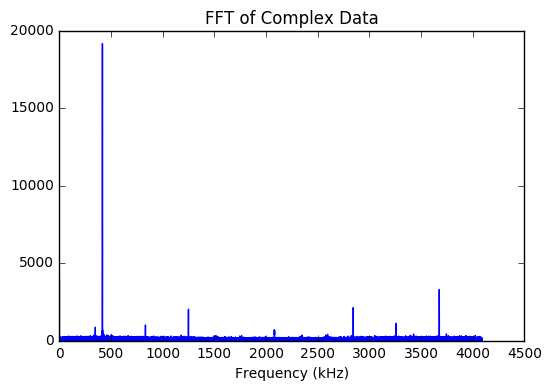

In [40]:
plt.plot(f, np.abs(ffC))

plt.title("FFT of Complex Data")
plt.xlabel("Frequency (kHz)")
plt.show()

# Get a Gold Code

- Gold Code must be generated as though it were sampled at the sampling rate
- 1023 chips that must take 1ms to pass through (due to chipping rate)
- We are sampling @ 4.092 MHz
- So we need the GC to repeat each chip 4 times before going to the next chip.
- The numpy.repeat() function does this exactly

## SVs in this data:

#SV| Doppler(Hz)| Alt (deg)| Az (deg)
---|------------|----------|--------
13 |     3195   | 23.3| 216.5
11 |     3097   |  5.8|  39.0
28 |     1581   | 43.4|  76.3
17 |      359   | 80.6|  80.1
12 |    -2825   |  5.6| 277.7
15 |     1994   | 25.7| 255.4
01 |     1797   | 19.3|  44.4
24 |    -2592   | 31.9| 309.6
30 |     3378   | 13.4| 141.2
06 |    -3321   | 21.1| 159.8

In [60]:
#code = np.repeat(CodeGen.getCode(1023), 4)

#Choose which satellite's C/A code is generated
Satellite = 15

# Create list of C/A code Taps, for simpler sat selection",
#sat = [(2,6),(3,7),(4,8),(5,9),(1,9),(2,6),(1,8),(2,9),(3,10),(2,3),(3,4),(5,6),(6,7),(7,8),(8,9),(9,10),(1,4),(2,5),(3,6),(4,7),(5,8),(6,9),(1,3),(4,6),(5,7),(6,8),(7,9),(8,10),(1,6),(2,7),(3,8),(4,9),(5,10),(4,10),(1,7),(2,8),(4,10)]
sat = [(1,5),(2,6),(3,7),(4,8),(0,8),(1,5),(0,7),(1,8),(2,9),(1,2),(2,3),(4,5),(5,6),(6,7),(7,8),(8,9),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(0,2),(3,5),(4,6),(5,7),(6,8),(7,9),(0,5),(1,6),(2,7),(3,8),(4,9),(3,9),(0,6),(1,7),(3,9)]

# Create Code Generator object for chosen Satellite
CodeGen = GoldCode(sat[Satellite - 1]) # Index starts at zero

# Generate CA Code
CACode = CodeGen.getCode(1023)

# Reformat GC to have -1 in place of 0 (Now done in GoldCode)
#for n,i in enumerate(CACode):
#    if i==0:
#        CACode[n]=-1
        
# Repeat each chip 4 times (See markdown in above cell), to match our ADC sample frequency",
CACodeSampled = np.repeat(CACode,4)
print("Satellite chosen: %d, with tap: %s" %(Satellite,str(sat[Satellite - 1])))

# Repeat entire array for each ms of data sampled
CACodeSampled = np.tile(CACodeSampled,int(SampleLength*1000))
print(len(CACodeSampled))

Satellite chosen: 15, with tap: (7, 8)
57288


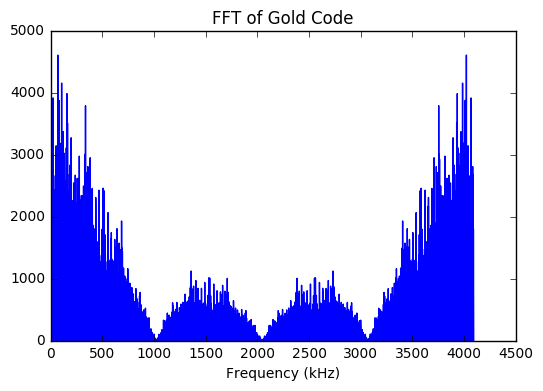

In [61]:
Codefft = np.fft.fft(CACodeSampled, nfft)

plt.plot(f, np.abs(Codefft))
plt.title("FFT of Gold Code")
plt.xlabel("Frequency (kHz)")
plt.show()

## Function to find second largest value

In [62]:
# This will return second largest value
# It will also ignore any value that is close to the second largest value
def GetSecondLargest(DataList):
    # Make sure is a numpy array
    DataArray = np.array(DataList)
    
    # Find largest value
    Largest = np.amax(DataArray)
    LargestIndex = np.argmax(DataArray)
    print("Largest value: %f, at position: %d"%(Largest,LargestIndex))
    
    # Reduce value by a percent to prevent near-identical values from being selected
    ScaleAmount = 0.95
    ScaledLargest = ScaleAmount*Largest
    SecondLargest = 0
    SecondLargestIndex = 0
    
    for ind,val in enumerate(DataArray):
        if val < ScaledLargest:
            if val > SecondLargest:
                #Ignore adjacent bins to Largest
                if (np.abs(LargestIndex-ind) > 10):
                    SecondLargest = val
                    SecondLargestIndex = ind
    
    print("Second largest value: %f, at position: %d"%(SecondLargest,SecondLargestIndex))
    return SecondLargest

# Complex Conjugate of Gold Code fft

Take the complex conjugate of the Gold Code [real(fft) - imag(fft)j], and then multiply it by the IQ fft. If this is done correctly there should be a spike about $10^7$ times as high as the noise. 



Length of t: 57288
Length of IFFT: 57288


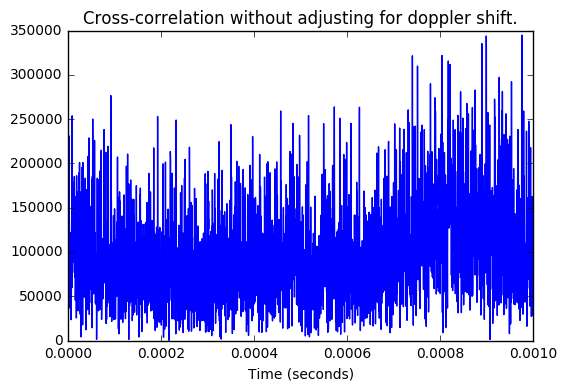

Largest value: 344817.777778, at position: 3994
Second largest value: 321777.777778, at position: 3290
SNR: 0.300336
Max Value: 344817.777778, at freqshift: 0, with index 20362


In [63]:
GCConj = np.conjugate(Codefft)

result = np.fft.ifft(GCConj * ffC,nfft)

resultSQ = np.real(result*np.conjugate(result))

t = np.linspace(0,SampleLength,nfft,endpoint=True) 
print("Length of t: %d" %(len(t)))
print("Length of IFFT: %d" %(len(resultSQ)))

plt.plot(t,resultSQ)

# Zoom in to one ms
xmin,xmax = plt.xlim()
plt.xlim(xmin,xmin + 0.001)

plt.title("Cross-correlation without adjusting for doppler shift.")
plt.xlabel("Time (seconds)")
plt.show()

# Search for largest value in 1 ms worth of data
SecondLargestValue = GetSecondLargest(resultSQ[0:int(fs*0.001)])

# Pseudo SNR
ResultsSNR = 10*np.log10(np.amax(resultSQ)/SecondLargestValue)
print("SNR: %f"%(ResultsSNR))

print("Max Value: %f, at freqshift: %d, with index %d"%(np.amax(resultSQ),0,np.argmax(resultSQ)))

# Notes

- From book appendix: we should look for the top 2 peaks, and use the ratio to determine whether there is a signal or just noise
- We should get the C code running and be sure to compare results. Acquisition works in the C code, but tracking is untested

## Shift frequency using multiplication by a complex exponential

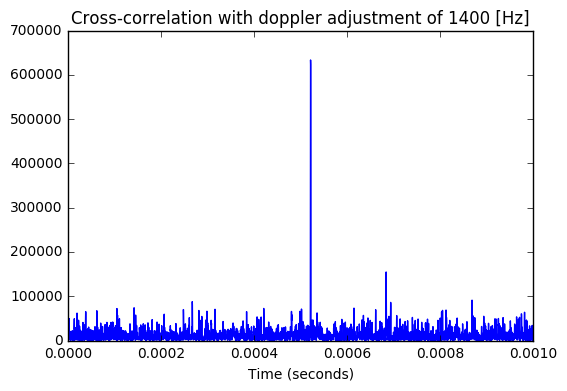

Largest value: 633417.501498, at position: 2133
Second largest value: 154723.242194, at position: 2798
SNR: 6.121345
Max Value: 633417.501498, at freqshift: 1400, with index: 2133


In [64]:
freqShift = 1400 #[Hz] -20


# Initialize complex array
CDataShifted = data.CData*np.exp(1j*2*np.pi*freqShift*data.t)
fftCDataShifted = np.fft.fft(CDataShifted,nfft)

result = np.fft.ifft(GCConj * fftCDataShifted,nfft)
resultSQ = np.real(result*np.conjugate(result))
resultLog = 10*np.log10(resultSQ)

plt.plot(t,resultSQ)
plt.title("Cross-correlation with doppler adjustment of %d [Hz]"%(freqShift))
plt.xlabel("Time (seconds)")

# Zoom in to one ms
xmin,xmax = plt.xlim()
plt.xlim(xmin,xmin + 0.001)
plt.show()

# Search for largest value in 1 ms worth of data
SecondLargestValue = GetSecondLargest(resultSQ[0:int(fs*0.001)])

# Pseudo SNR
ResultsSNR = 10*np.log10(np.amax(resultSQ)/SecondLargestValue)
print("SNR: %f"%(ResultsSNR))

print("Max Value: %f, at freqshift: %d, with index: %d"%(np.amax(resultSQ),freqShift,np.argmax(resultSQ)))

##### Shift frequency by rotating FFT array

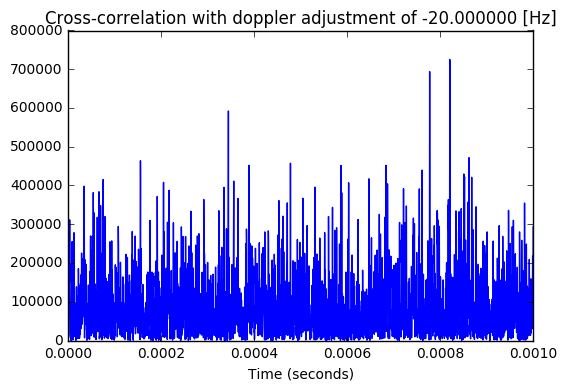

Largest value: 725172.887014, at position: 3358
Second largest value: 592297.370588, at position: 1410
SNR: 0.879018
Max Value: 725172.887014, at freqshift: -600, with index: 113842


In [68]:
freqRoll = -1 #[Bin number (See BinWidth for frequency resolution)]

# Initialize complex array
fftCDataShifted = np.roll(np.fft.fft(data.CData,nfft),freqRoll)

result = np.fft.ifft(GCConj * fftCDataShifted,nfft)
resultSQ = np.real(result*np.conjugate(result))
resultLog = 20*np.log10(np.abs(result))

plt.plot(t,resultSQ)
plt.title("Cross-correlation with doppler adjustment of %f [Hz]"%(freqRoll*BinWidth))
plt.xlabel("Time (seconds)")

# Zoom in to one ms
xmin,xmax = plt.xlim()
plt.xlim(xmin,xmin + 0.001)
plt.show()

# Search for largest value in 1 ms worth of data
SecondLargestValue = GetSecondLargest(resultSQ[0:int(fs*0.001)])

# Pseudo SNR
ResultsSNR = 10*np.log10(np.amax(resultSQ)/SecondLargestValue)
print("SNR: %f"%(ResultsSNR))

print("Max Value: %f, at freqshift: %d, with index: %d"%(np.amax(resultSQ),freqShift,np.argmax(resultSQ)))

## Multiply original signal by shifted Gold Code

204600
204600


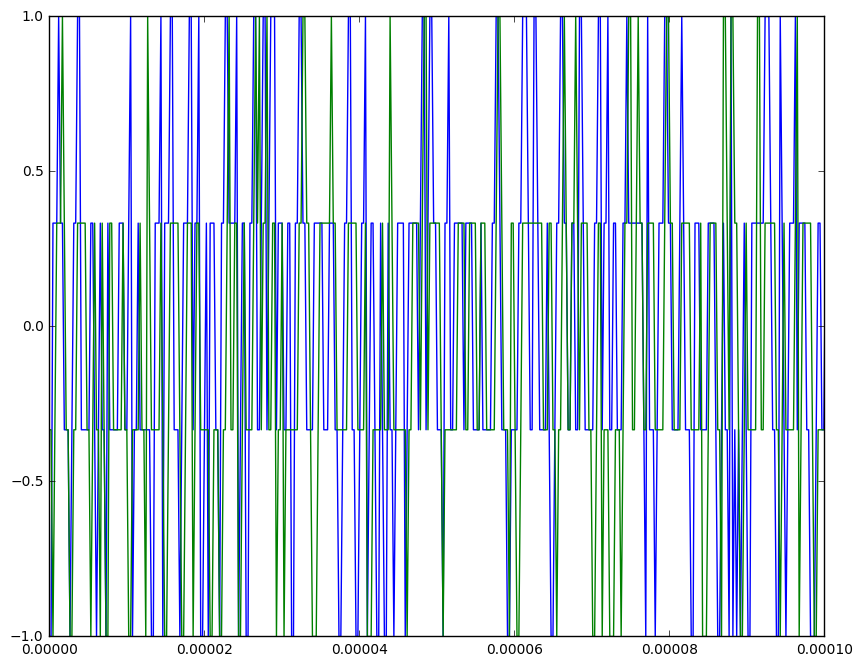

In [53]:
#      NEEDS some modifications

# Shift gold code by maximum index from prior cell
CACode_Shifted = CACodeSampled
np.roll(CACode_Shifted,np.argmax(resultLog))

print(len(data.CData))
print(len(CACode_Shifted))
# Multiply by frequency shifted complex data: 
Result = CACode_Shifted*data.CData

plt.figure(figsize=(10,8))
plt.plot(t,np.real(Result))
plt.plot(t, np.imag(Result))
plt.xlim(0,0.0001)
plt.show()

## Shift through frequency and satellite range

In [55]:
# Choose what frequencies and satellites to increment over
StartingFrequencyShift = -10*10**3
EndingFrequencyShift = 10*10**3
FrequencyShiftIncrement = 1*10**3
FrequencyList = range(StartingFrequencyShift,EndingFrequencyShift + FrequencyShiftIncrement,FrequencyShiftIncrement)

StartingSatellite = 1
EndingSatellite = 30
SatelliteList = range(StartingSatellite, EndingSatellite + 1)

# Create list of C/A code Taps, for simpler sat selection",
#sat = [(2,6),(3,7),(4,8),(5,9),(1,9),(2,6),(1,8),(2,9),(3,10),(2,3),(3,4),(5,6),(6,7),(7,8),(8,9),(9,10),(1,4),(2,5),(3,6),(4,7),(5,8),(6,9),(1,3),(4,6),(5,7),(6,8),(7,9),(8,10),(1,6),(2,7),(3,8),(4,9),(5,10),(4,10),(1,7),(2,8),(4,10)]
sat = [(1,5),(2,6),(3,7),(4,8),(0,8),(1,5),(0,7),(1,8),(2,9),(1,2),(2,3),(4,5),(5,6),(6,7),(7,8),(8,9),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(0,2),(3,5),(4,6),(5,7),(6,8),(7,9),(0,5),(1,6),(2,7),(3,8),(4,9),(3,9),(0,6),(1,7),(3,9)]

# Create array to store max values, freq ranges, per satellite
SatMax = np.zeros((len(SatelliteList),len(FrequencyList),3))

satInd = 0 
# Loop through selected satellites
for curSat in SatelliteList: 
    # Create Code Generator object for chosen Satellite
    CodeGen = GoldCode(sat[curSat - 1]) # Index starts at zero
    
    # Generate CA Code
    CACode = CodeGen.getCode(1023)
    
    # Reformat GC to have -1 in place of 0
    for n,i in enumerate(CACode):
        if i==0:
            CACode[n]=-1
            
    # Repeat each chip 4 times (See markdown in above cell), to match our ADC sample frequency",
    CACodeSampled = np.repeat(CACode,4)
    #print("Satellite chosen: %d, with tap: %s" %(Satellite,str(sat[Satellite - 1])))
    
    # Repeat entire array for each ms of data sampled
    CACodeSampled = np.tile(CACodeSampled,NumberOfMilliseconds)
    Codefft = np.fft.fft(CACodeSampled,nfft)
    GCConj = np.conjugate(Codefft)
    
    freqInd = 0
    # Loop through all frequencies
    for curFreq in FrequencyList:
        # Initialize complex array
        CDataShifted = np.zeros(len(data.CData), dtype=np.complex)
        
        # Shift frequency using complex exponential 
        CDataShifted = data.CData*np.exp(1j*2*np.pi*curFreq*t)

        fftCDataShifted = np.fft.fft(CDataShifted,nfft)
        
        result = np.fft.ifft(GCConj * fftCDataShifted,nfft)
        
        resultSQ = np.abs(result) ** 2
        resultSQ = np.real(resultSQ)
        maxAbsSquared = np.max(resultSQ)
        
        resultLog = 10*np.log10(resultSQ)
        maxdB = np.max(resultLog)
        
        print("Sat: %d, Doppler Shift: %8.2f, MaxVal: %8.2f, MaxVal (dB): %8.4f" %(curSat,curFreq, maxAbsSquared, maxdB))
        
        # Store results in array
        SatMax[satInd,freqInd,0] = maxAbsSquared
        SatMax[satInd,freqInd,1] = maxdB
        SatMax[satInd,freqInd,2] = np.real(np.sum(resultLog))
        freqInd = freqInd + 1
    satInd = satInd+1



Sat: 1, Doppler Shift: -10000.00, MaxVal: 1487156.50, MaxVal (dB):  61.7236
Sat: 1, Doppler Shift: -9000.00, MaxVal: 913796.66, MaxVal (dB):  59.6085
Sat: 1, Doppler Shift: -8000.00, MaxVal: 2189231.75, MaxVal (dB):  63.4029
Sat: 1, Doppler Shift: -7000.00, MaxVal: 2185694.85, MaxVal (dB):  63.3959
Sat: 1, Doppler Shift: -6000.00, MaxVal: 895365.98, MaxVal (dB):  59.5200
Sat: 1, Doppler Shift: -5000.00, MaxVal: 1445028.30, MaxVal (dB):  61.5988
Sat: 1, Doppler Shift: -4000.00, MaxVal: 1108867.54, MaxVal (dB):  60.4488
Sat: 1, Doppler Shift: -3000.00, MaxVal: 1106801.90, MaxVal (dB):  60.4407
Sat: 1, Doppler Shift: -2000.00, MaxVal: 1781861.45, MaxVal (dB):  62.5087
Sat: 1, Doppler Shift: -1000.00, MaxVal: 1473029.12, MaxVal (dB):  61.6821
Sat: 1, Doppler Shift:     0.00, MaxVal: 754887.56, MaxVal (dB):  58.7788
Sat: 1, Doppler Shift:  1000.00, MaxVal: 1979641.84, MaxVal (dB):  62.9659
Sat: 1, Doppler Shift:  2000.00, MaxVal: 1181129.62, MaxVal (dB):  60.7230
Sat: 1, Doppler Shift:  300

In [ ]:
print(np.argmax(SatMax[0,:,0]))
print(FrequencyList[np.argmax(SatMax[0,:,0])])
print(np.argmax(SatMax[0,:,1]))
print(FrequencyList[np.argmax(SatMax[0,:,1])])
print(np.argmax(SatMax[0,:,2]))
print(FrequencyList[np.argmax(SatMax[0,:,2])])

In [ ]:
for i in range(StartingSatellite,EndingSatellite+1):
    plt.plot(FrequencyList,SatMax[i-1,:,0])
    plt.title("Satellite: %d, AbsSQ Max Value"%(i))
    plt.show()

    plt.plot(FrequencyList,SatMax[i-1,:,1])
    plt.title("Satellite: %d, dB Max Value"%(i))
    plt.show()
    
    plt.plot(FrequencyList,SatMax[i-1,:,2])
    plt.title("Satellite: %d, dB SUM"%(i))
    plt.show()


array([  0.00000000e+00,   2.44380471e-07,   4.88760942e-07, ...,
         4.99995112e-02,   4.99997556e-02,   5.00000000e-02])